In [1]:
# Запустите код ниже, если библиотека XGboost не установлена
#!pip install xgboost

import numpy as np 
import pandas as pd 
import csv as csv
from xgboost import plot_importance, XGBRegressor, XGBRFClassifier

# from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV  

# from scipy.stats import skew
# from collections import OrderedDict

В основе `XGBoost` лежит алгоритм градиентного бустинга деревьев решений. Градиентный бустинг — это техника машинного обучения для задач классификации и регрессии, которая строит модель предсказания в форме ансамбля слабых предсказывающих моделей, обычно деревьев решений. Обучение ансамбля проводится последовательно в отличие, например от бэггинга. На каждой итерации вычисляются отклонения предсказаний уже обученного ансамбля на обучающей выборке. Следующая модель, которая будет добавлена в ансамбль будет предсказывать эти отклонения. Таким образом, добавив предсказания нового дерева к предсказаниям обученного ансамбля мы можем уменьшить среднее отклонение модели, которое является таргетом оптимизационной задачи. Новые деревья добавляются в ансамбль до тех пор, пока ошибка уменьшается, либо пока не выполняется одно из правил "ранней остановки".

## Parkinson's desease

### Ссылка на датасет
https://www.kaggle.com/datasets/vikasukani/parkinsons-disease-data-set/data

### Набор данных о болезни Паркинсона
Этот набор данных состоит из ряда биомедицинских измерений голоса у 31 человека, 23 из которых страдали болезнью Паркинсона (БП). Каждый столбец в таблице представляет собой определенный показатель голоса, а каждая строка соответствует одной из 195 голосовых записей этих людей (столбец "имя"). Основная цель сбора данных - отличить здоровых людей от людей с БП, согласно столбцу "статус", который имеет значение 0 для здоровых и 1 для больных БП.

Данные представлены в формате ASCII CSV. Строки файла CSV содержат экземпляр, соответствующий одной записи голоса. На каждого пациента приходится около шести записей, имя пациента указано в первом столбце. Для получения дополнительной информации или комментариев, пожалуйста, обращайтесь к Максу Литтлу (@little robots.ox.ac.uk).

- MDVP: Fo (Гц) - Средняя основная частота вокала
- MDVP:Fhi (Гц) - Максимальная основная частота вокала
- MDVP:Flo (Гц) - Минимальная основная частота вокала
- MDVP: Дрожание (%), MDVP: Дрожание (Абс.), MDVP:RAP, MDVP:PPQ, Джиттер: DDP - Несколько показателей изменения основной частоты
- MDVP: Мерцание, MDVP: Мерцание (дБ), Мерцание: APQ3, Мерцание:APQ5, MDVP:APQ, Мерцание:DDA - Несколько показателей изменения амплитуды
- NHR, HNR - Два показателя соотношения шума и тональных составляющих в состоянии голоса
- status - Состояние здоровья субъекта (один) - болезнь Паркинсона, (ноль) - здоровый
- RPDE, D2 - Два нелинейных показателя динамической сложности
- DFA - Показатель фрактального масштабирования сигнала
- spread1, spread2, PPE - Три нелинейных показателя изменения основной частоты

In [2]:
df = pd.read_csv("data/parkinsons.data")

In [3]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [4]:
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [5]:
df.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

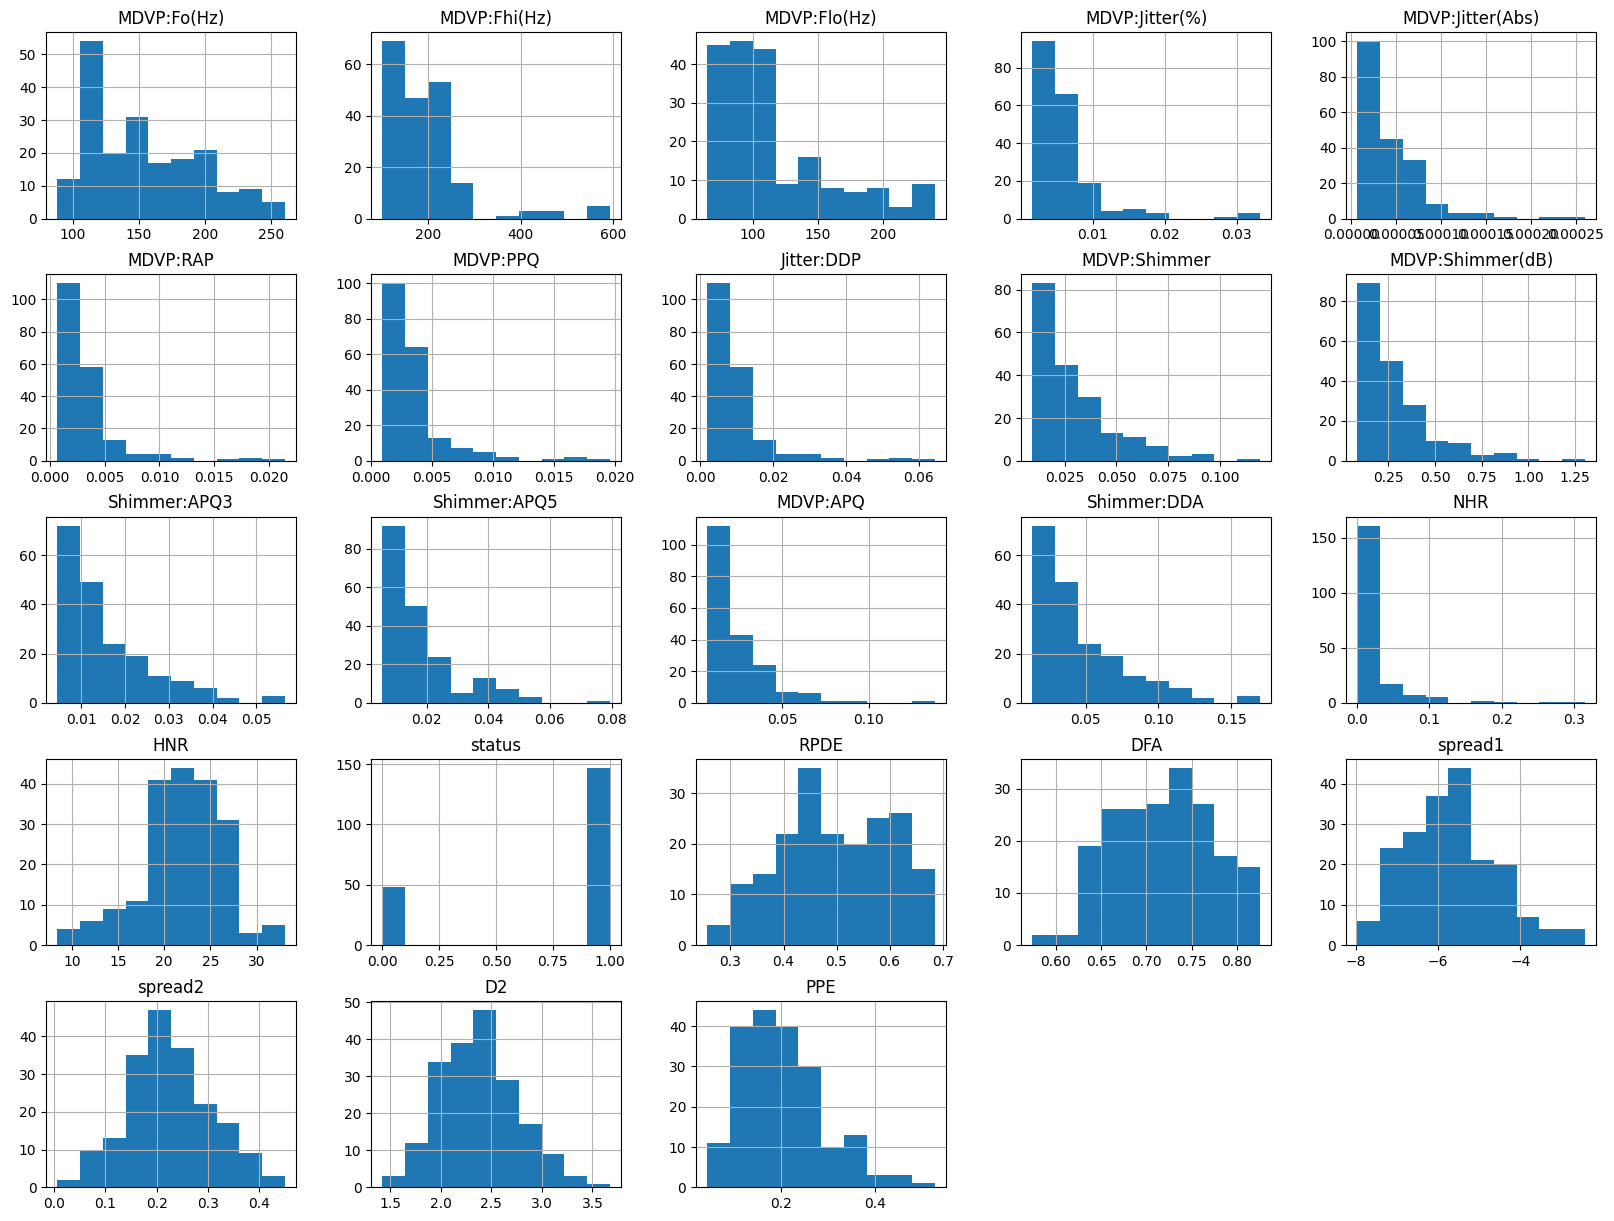

In [6]:
df.hist(figsize=(20,15));

In [7]:
features = df.loc[:,df.columns!='status'].values[:,1:]  # features — все столбцы, кроме status и name
labels = df.loc[:,'status'].values

In [8]:
df['status'].value_counts()

status
1    147
0     48
Name: count, dtype: int64

In [9]:
# Масштабирование
scaler = MinMaxScaler((-1,1))
X = scaler.fit_transform(features)
y = labels

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
model = XGBRFClassifier()
model.fit(X_train,y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=None, ...)

In [12]:
y_pred=model.predict(X_test)
print(accuracy_score(y_test, y_pred)*100)

91.83673469387756


In [13]:
print(confusion_matrix(y_test, y_pred))

[[ 7  4]
 [ 0 38]]


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.90      1.00      0.95        38

    accuracy                           0.92        49
   macro avg       0.95      0.82      0.86        49
weighted avg       0.93      0.92      0.91        49



> # Задание
>
> Используя все ранее изученные алгоритмы, найдите оптимальный для решения выявления пациентов с болезнью Паркинсона.

# Пробуем логистическую регрессию

In [15]:
# # пробуем добавить новые признаки
# df_NEW = pd.read_csv("data/parkinsons.data")
# df_NEW['Fo_Fhi_ratio'] = df_NEW['MDVP:Fo(Hz)'] / (df_NEW['MDVP:Fhi(Hz)'] + 1e-5)
# # df_NEW['Flo_Fhi_diff'] = df_NEW['MDVP:Fhi(Hz)'] - df_NEW['MDVP:Flo(Hz)']
# df_NEW['Jitter_Shimmer_product'] = df_NEW['MDVP:Jitter(%)'] * df_NEW['MDVP:Shimmer']
# df_NEW['Jitter_Shimmer_sum'] = df_NEW['MDVP:Jitter(%)'] + df_NEW['MDVP:Shimmer']
# df_NEW['log_Fo'] = np.log(df_NEW['MDVP:Fo(Hz)'] + 1e-5)

# features = df_NEW.loc[:,df_NEW.columns!='status'].values[:,1:]
# labels = df_NEW.loc[:,'status'].values

# # Масштабирование
# scaler = MinMaxScaler((-1,1))
# X = scaler.fit_transform(features)
# y = labels

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
param_LogReg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

LogReg = LogisticRegression(random_state=42)

GS_LogReg = GridSearchCV(estimator=LogReg, param_grid=param_LogReg, scoring='accuracy', cv=10, n_jobs=-1, verbose=2)
GS_LogReg.fit(X_train, y_train)

best_LogReg = GS_LogReg.best_estimator_
y_pred_LogReg = best_LogReg.predict(X_test)
accuracy_LogReg = accuracy_score(y_test, y_pred_LogReg)*100

Fitting 10 folds for each of 40 candidates, totalling 400 fits


In [18]:
print("Наилучшее сочетание параметров:", best_LogReg)
print('Точность модели логистической регрессии на тестовой выборке: ' + str(round(accuracy_LogReg, 14)) + ' %.')

Наилучшее сочетание параметров: LogisticRegression(C=100, penalty='l1', random_state=42, solver='liblinear')
Точность модели логистической регрессии на тестовой выборке: 91.83673469387756 %.


Интересный результат однако...

In [19]:
print(confusion_matrix(y_test, y_pred_LogReg))

[[ 7  4]
 [ 0 38]]


In [20]:
print(classification_report(y_test, y_pred_LogReg))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.90      1.00      0.95        38

    accuracy                           0.92        49
   macro avg       0.95      0.82      0.86        49
weighted avg       0.93      0.92      0.91        49



In [21]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0])

In [22]:
y_pred_LogReg

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0])

# Пробуем SVM

In [23]:
from sklearn.svm import SVC

In [24]:
param_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 1],
    #'gamma': [0.1, 1, 10],
    'degree': [3, 4, 5],
    'class_weight': [None, 'balanced']
}

svm = SVC(random_state=42, probability=True)

GS_svm = GridSearchCV(estimator=svm, param_grid=param_svm, scoring='accuracy', cv=10, n_jobs=-1, verbose=2)
GS_svm.fit(X_train, y_train)

best_svm = GS_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)*100

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


In [25]:
print("Наилучшее сочетание параметров:", best_svm)
print('Точность модели логистической регрессии на тестовой выборке: ' + str(round(accuracy_svm, 14)) + ' %.')

Наилучшее сочетание параметров: SVC(C=10, gamma=1, probability=True, random_state=42)
Точность модели логистической регрессии на тестовой выборке: 95.91836734693877 %.


In [26]:
print(confusion_matrix(y_test, y_pred_svm))

[[ 9  2]
 [ 0 38]]


In [27]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.95      1.00      0.97        38

    accuracy                           0.96        49
   macro avg       0.97      0.91      0.94        49
weighted avg       0.96      0.96      0.96        49



**class_weight='balanced' подогнал до 91.83673469387756, gamma=1 до 95.91836734693877 %.**

# Пробуем дерево решений

In [28]:
from sklearn.tree import DecisionTreeClassifier

In [29]:
param_DTree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 6, 7, 8, 10, 12],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

DTree = DecisionTreeClassifier(random_state=42)

GS_DTree = GridSearchCV(estimator=DTree, param_grid=param_DTree, scoring='accuracy', cv=10, n_jobs=-1, verbose=2)
GS_DTree.fit(X_train, y_train)

best_DTree = GS_DTree.best_estimator_
y_pred_DTree = best_DTree.predict(X_test)
accuracy_DTree = accuracy_score(y_test, y_pred_DTree)*100

Fitting 10 folds for each of 1152 candidates, totalling 11520 fits


In [30]:
print("Наилучшее сочетание параметров:", best_DTree)
print('Точность модели логистической регрессии на тестовой выборке: ' + str(round(accuracy_DTree, 14)) + ' %.')

Наилучшее сочетание параметров: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, min_samples_leaf=3, random_state=42)
Точность модели логистической регрессии на тестовой выборке: 87.75510204081633 %.


# Вывод

Для набора данных о болезни Паркинсона самую большую точность получилось добиться от модели SVC.
